# 機械学習

## 目次

- k-最近傍法
- ロジスティック回帰
- 決定木
- ランダムフォレスト
- 勾配ブースティング
- 非線形サポートベクターマシン
- ハイパーパラメータチューニングチートシート

## Section4 各アルゴリズムごとの実装例

In [1]:
# # Googleドライブのマウント（Colab使いのみ）

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/dlc/week1

In [2]:
# 図表が使えるようにする

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# データの分割

from sklearn.model_selection import train_test_split
import pandas as pd

# 訓練データのロード
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test_id = df_test['PassengerId']


In [4]:
# 前処理をする関数
## train : pd.DataFrame 
## test : pd.DataFrame
def preProcessing(train, test):
    
    # PassengerId, Name, Ticket, Cabinを削除する
    train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    
    # Ageの欠損値を中央値で埋める
    fill_age = train['Age'].median()
    train['Age'] = train['Age'].fillna(fill_age)
    test['Age'] = test['Age'].fillna(fill_age)
    
    # Fareの欠損値を平均値で埋める
    fare_ave = train['Fare'].mean()
    train['Fare'] = train['Fare'].fillna(fare_ave)
    test['Fare'] = test['Fare'].fillna(fare_ave)

    # Embarkedの欠損値を最頻値"S"で埋める
    fill_embarked = 'S'
    train['Embarked'] = train['Embarked'].fillna(fill_embarked)
    test['Embarked'] = test['Embarked'].fillna(fill_embarked)
    
    # 家族の数(Family_size)という特徴量を作る
    train['Family_size'] = train['SibSp'] + train['Parch'] + 1
    test['Family_size'] = test['SibSp'] + test['Parch'] + 1

    # SibSpとParchを削除する
    train = train.drop(['SibSp', 'Parch'], axis=1)
    test = test.drop(['SibSp', 'Parch'], axis=1)
    
    # カテゴリ変数をOne-Hotエンコーディング
    train = pd.get_dummies(train, columns=['Sex', 'Pclass', 'Embarked'])
    test = pd.get_dummies(test, columns=['Sex', 'Pclass', 'Embarked'])
    
    return train, test

In [5]:
# 前処理
train, test = preProcessing(df_train, df_test)

# 特徴と正解ラベルに分ける
feature = train.drop(['Survived'], axis=1)
target = train['Survived']

# 検証データ20%で分割する
X_train, X_val, y_train, y_val = train_test_split(feature, target, test_size=0.2, random_state=1)

In [6]:
# GridSearchCVの結果をヒートマップで表示する関数
def plotHeatmap(model):
    
    # チューニング対象のパラメータを特定する
    params = [k for k in model.cv_results_.keys() if k.startswith('param_')]
    
    if len(params) != 2: 
        # ヒートマップの行、列、値に使うキーを定義する
        index = ''
        columns = params[0]
        values = 'mean_test_score'

        # gridから必要なキーのみを抽出する
        df_dict = {k: model.cv_results_[k] for k in model.cv_results_.keys() & {index, columns, values}}

        # dictをDataFrameに変換
        df = pd.DataFrame(df_dict)
        df[''] = ''
        
    else:
        # ヒートマップの行、列、値に使うキーを定義する
        index = params[0]
        columns = params[1]
        values = 'mean_test_score'

        # gridから必要なキーのみを抽出する
        df_dict = {k: model.cv_results_[k] for k in model.cv_results_.keys() & {index, columns, values}}

        # dictをDataFrameに変換
        df = pd.DataFrame(df_dict)
    
    data = df.pivot(index=index, columns=columns, values=values)
    sns.heatmap(data, annot=True, fmt='.3f')

In [7]:
from sklearn.metrics import confusion_matrix

# 混同行列を表示する関数
def plotConfusionMatrix(model):
    
    best = model.best_estimator_
    # 混同行列作成
    pred_model = best.predict(X_val)
    conf_matrix = confusion_matrix(y_val, pred_model)

    # データフレーム作成
    class_names = ['died', 'survived']
    df_knn_conf_matrix = pd.DataFrame(conf_matrix,index=class_names,columns=class_names)

    # グラフ作成
    sns.heatmap(df_knn_conf_matrix, annot=True, cbar=None, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    # レポートも表示
    print("Accuracy score of Validation: {:.2f}".format(best.score(X_val, y_val)))
    print(classification_report(y_val, pred_model, target_names=['died', 'survived']))

### 4.1 k-最近傍法 (K Nearest Neighbor)

**メリット**
- モデルが理解しやすい
- あまり調整しなくても性能が出やすい
- モデル構築が高速

**デメリット**
- 訓練セットが大きくなると予測が遅くなる
  - 実際に使う時には前処理必須
- 疎（特徴量の多くが0）なデータセットに対しては十分な性能が出にくい

In [8]:
# knnを学習させてみる

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11]}
knn_model = \
  GridSearchCV(
    KNeighborsClassifier()
    , knn_params
    , cv=5
    , return_train_score=True
  )
knn_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]},
             return_train_score=True)

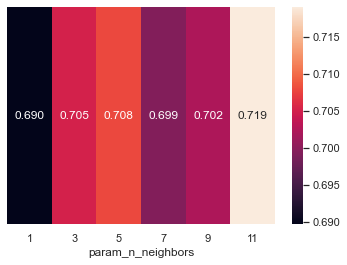

In [9]:
plotHeatmap(knn_model)

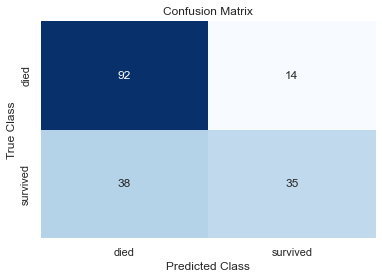

Accuracy score of Validation: 0.71
              precision    recall  f1-score   support

        died       0.71      0.87      0.78       106
    survived       0.71      0.48      0.57        73

    accuracy                           0.71       179
   macro avg       0.71      0.67      0.68       179
weighted avg       0.71      0.71      0.70       179



In [10]:
plotConfusionMatrix(knn_model)

### 4.2 ロジスティック回帰 (Logistic Regression)

**メリット**
- 訓練、予測ともに高速
- 大きなデータセット○
- 疎なデータセット○


**デメリット**
- 収束しないことがある
- 予測手法は理解しやすい反面、係数がなぜその値になっているのかは必ずしも自明ではない

In [11]:
from sklearn.linear_model import LogisticRegression

lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lr_model =  \
  GridSearchCV(
    LogisticRegression(max_iter=1000)
    , lr_params
    , cv=5
    , return_train_score=True
  )
lr_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

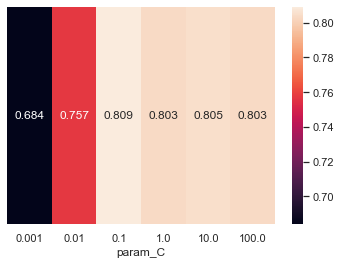

In [12]:
plotHeatmap(lr_model)

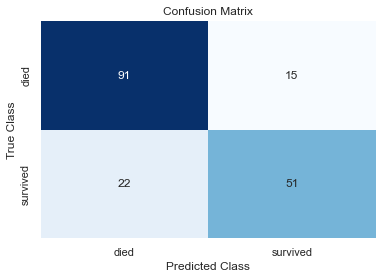

Accuracy score of Validation: 0.79
              precision    recall  f1-score   support

        died       0.81      0.86      0.83       106
    survived       0.77      0.70      0.73        73

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [13]:
plotConfusionMatrix(lr_model)

### 4.3 決定木 (Decision Tree)

**メリット**
- 可視化可能で、理解しやすい
- ハイパーパラメータは3つのうちいずれか1つをいじるだけでいい

**デメリット**
- 過剰適合しやすい

In [14]:
from sklearn.tree import DecisionTreeClassifier

dtree_params = {
    'max_depth':[1, 2, 3, 4, 5],
    'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split':[2, 3, 4, 5]
}
dtree_model = \
  GridSearchCV(
    DecisionTreeClassifier()
    , dtree_params
    , cv=5
    , return_train_score=True
  )
dtree_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5]},
             return_train_score=True)

In [15]:
print("Best cross-validation score: {:.2f}".format(dtree_model.best_score_))
print("Best parameters: {}".format(dtree_model.best_params_))

Best cross-validation score: 0.83
Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


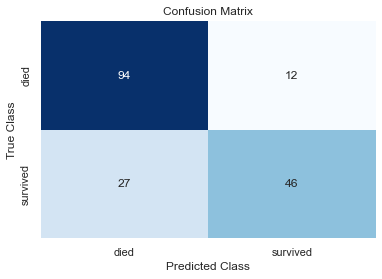

Accuracy score of Validation: 0.78
              precision    recall  f1-score   support

        died       0.78      0.89      0.83       106
    survived       0.79      0.63      0.70        73

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



In [16]:
plotConfusionMatrix(dtree_model)

### 4.4 ランダムフォレスト (Random Forest)

**メリット**
- 強力
- ハイパーパラメータチューニングをさほど必要としない
- スケール変換が不要

**デメリット**
- 訓練にも予測にも時間がかかる
- メモリを大量に使う
- 疎なデータにはうまく機能しない

In [17]:
from sklearn.ensemble import RandomForestClassifier

randforest_params = {
    'n_estimators' : [100, 500, 1000],
    'criterion' : ['gini'],
    'min_samples_split' : [3, 5, 10],
    'max_depth' : [5, 10, 15],
    'random_state' : [1],
    'verbose' : [False],
}
randforest_model = \
  GridSearchCV(
    RandomForestClassifier()
    , randforest_params
    , cv=5
    , return_train_score=True
  )
randforest_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 500, 1000], 'random_state': [1],
                         'verbose': [False]},
             return_train_score=True)

In [18]:
print("Best cross-validation score: {:.2f}".format(randforest_model.best_score_))
print("Best parameters: {}".format(randforest_model.best_params_))

Best cross-validation score: 0.85
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 1, 'verbose': False}


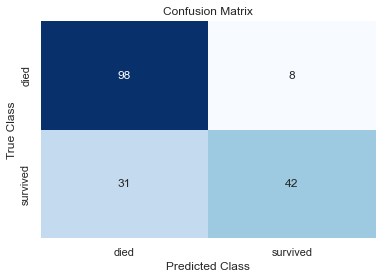

Accuracy score of Validation: 0.78
              precision    recall  f1-score   support

        died       0.76      0.92      0.83       106
    survived       0.84      0.58      0.68        73

    accuracy                           0.78       179
   macro avg       0.80      0.75      0.76       179
weighted avg       0.79      0.78      0.77       179



In [19]:
plotConfusionMatrix(randforest_model)

### 4.5 勾配ブースティング (Gradient Boosting)

**メリット**
- かなり強力
- スケール変換が不要

**デメリット**
- 訓練にも予測にも時間がかかる
- メモリを大量に使う
- 疎なデータにはうまく機能しない
- ハイパーパラメータチューニングに気を使う必要がある

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {'n_estimators': list(range(20,101,20)),
             'learning_rate': [0.05, 0.10, 0.20]}
gb_model = \
  GridSearchCV(
    GradientBoostingClassifier(
      min_samples_split = 5, 
      min_samples_leaf = 50, 
      max_depth = 5, 
      max_features = 'sqrt', 
      subsample = 0.8)
    , gb_params
    , cv=5
    , return_train_score=True
  )
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=5,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=5,
                                                  subsample=0.8),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': [20, 40, 60, 80, 100]},
             return_train_score=True)

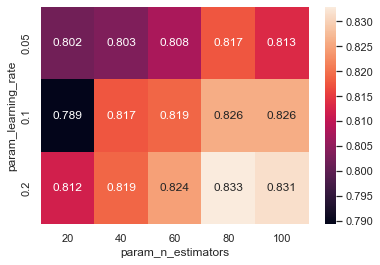

In [21]:
plotHeatmap(gb_model)

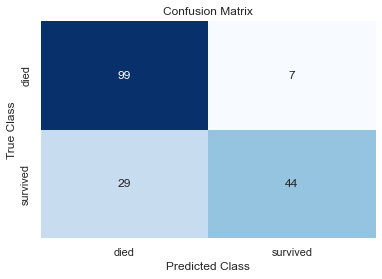

Accuracy score of Validation: 0.80
              precision    recall  f1-score   support

        died       0.77      0.93      0.85       106
    survived       0.86      0.60      0.71        73

    accuracy                           0.80       179
   macro avg       0.82      0.77      0.78       179
weighted avg       0.81      0.80      0.79       179



In [22]:
plotConfusionMatrix(gb_model)

### 4.6 非線形サポートベクターマシン (Non-linear SVM)

**メリット**
- 強力
- 特徴量が少なくても○

**デメリット**
- 訓練にも予測にも時間がかかる
- メモリを大量に使う
- データの前処理とハイパーパラメータチューニングが必須

In [23]:
from sklearn.svm import SVC

SVC_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
SVC_model = \
  GridSearchCV(
    SVC()
    , SVC_params
    , cv=5
    , return_train_score=True
  )
SVC_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

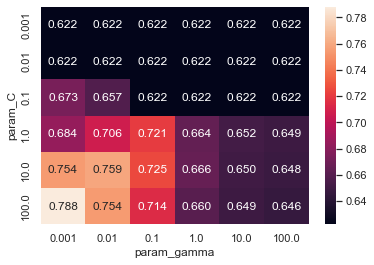

In [24]:
plotHeatmap(SVC_model)

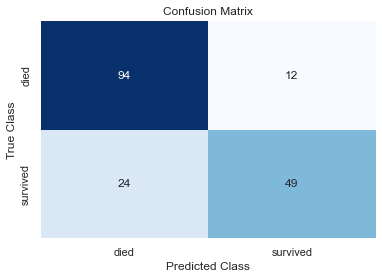

Accuracy score of Validation: 0.80
              precision    recall  f1-score   support

        died       0.80      0.89      0.84       106
    survived       0.80      0.67      0.73        73

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [25]:
plotConfusionMatrix(SVC_model)

### 4.7 ハイパーパラメータチューニングチートシート

|←適合不足|アルゴリズム名|過剰適合→|
|:--|:-:|--:|
|n_neighbors↑|k-最近傍法|n_neighbors↓|
|C↓|ロジスティック回帰|C↑|
|C↓|線形SVM|C↑|
|C↓, gamma↓|非線形SVM|C↑, gamma↑|
|max_depth↓|決定木|max_depth↑|
|alpha↑|Ridge回帰/Lasso回帰|alpha↓|

- alphaは大きなパラメータを罰する
- Cは誤判別を罰する

In [ ]:
# kaggleに提出するデータを作成

X_test = df_test

# 予測
results = model.predict(X_test)
results = pd.Series(results, name = 'Survived')

# データ作成
submission = pd.concat([df_test_id, results], axis = 1)
submission.to_csv('titanic_submission.csv', index = False)